In [1]:
import os
import json
import time
import pandas as pd
from src.gender import gender
from src.vycisti import vycisti
pd.set_option('display.max_columns', None)
df = pd.read_json(os.path.join("data", "filmy.json"))
with open(os.path.join("data_fixes", "opravy.json"), encoding="utf-8") as opravy:
    opravy = json.loads(opravy.read())
with open(os.path.join("data_fixes", "seznamy.json"), encoding="utf-8") as seznamy:
    seznamy = json.loads(seznamy.read())
with open(os.path.join("data_fixes", "zeny.json"), encoding="utf-8") as zeny:
    zeny = json.loads(zeny.read())
with open(os.path.join("data_fixes", "nelide.json"), encoding="utf-8") as nelide:
    nelide = json.loads(nelide.read())
df = vycisti(df, opravy)

2023/05/29 11:36:59 z 4555 řádků odstraněno 125. Aktuální dataframe má 4430 řádků.


## Dlouhý výpočet, kterým se nechceme zdržovat v sešitu věnovaném tvůrcům

In [2]:
profese = seznamy["profese"]
persony = pd.read_json(os.path.join("data", "persony.json"))
jmena_lidi = persony[persony["Osoba"] == "fyzická"]["Jméno"].to_list()

In [3]:
profese.remove("Účinkují")
profese.remove("Hudba, text a zpěv písně")
profese.remove("Hudba k písni")

In [4]:
def plose_jednoduse(x):
    seznam = []
    for y in x:
        if y == None:
            pass
        if isinstance(y, str):
            if y not in seznam:
                seznam.append(y)
        if isinstance(y, list):
            for z in y:
                if z not in seznam:
                    seznam.append(z)
    return(seznam)

In [5]:
def kolik_skoncilo(konce, jmena_lidi):
    st = time.time()
    konce["Lidé"] = konce[profese].values.tolist()
    konce["Lidé"] = konce["Lidé"].apply(lambda x: plose_jednoduse(x))
    konce = konce[["Copyright","Lidé","Film"]].explode("Lidé")
    konce = konce[konce["Lidé"].isin(jmena_lidi)]
    konce = konce.groupby("Copyright")["Lidé"].apply(lambda x: list(set(x)))
    konce = pd.DataFrame(konce).explode("Lidé")
    konce = konce.reset_index()  
    print(f"{len(konce)} člověkoletopočtů")
    konce["Příští film"] = konce[["Lidé","Copyright"]].apply(lambda x: konce[(konce["Lidé"] == x["Lidé"]) & (konce["Copyright"] > x["Copyright"])]["Copyright"].min(), axis = 1)
    konce = konce.rename(columns={"Lidé": "Jméno"})
    konce["Pauza"] = konce["Příští film"] - konce["Copyright"]
    print(f"čas výpočtu: {time.time() - st} s")
    return(konce)

In [6]:
konce = kolik_skoncilo(df, jmena_lidi)

95431 člověkoletopočtů
čas výpočtu: 1239.6945116519928 s


In [7]:
konce.to_json(os.path.join("data", "pauzy.json"), orient="records")

In [8]:
konce.sample(5)

,Copyright,Jméno,Příští film,Pauza
34547,1974,Anna Štrosová (5187),1976.0,2.0
37823,1977,Alena Procházková (14497),1978.0,1.0
40540,1979,Boris Moravec ml. (129629),1980.0,1.0
64650,2002,Boris Masník (1489),2003.0,1.0
51433,1987,Drahoslav Makovička (12737),1988.0,1.0


## Explorace

<AxesSubplot:xlabel='Copyright'>

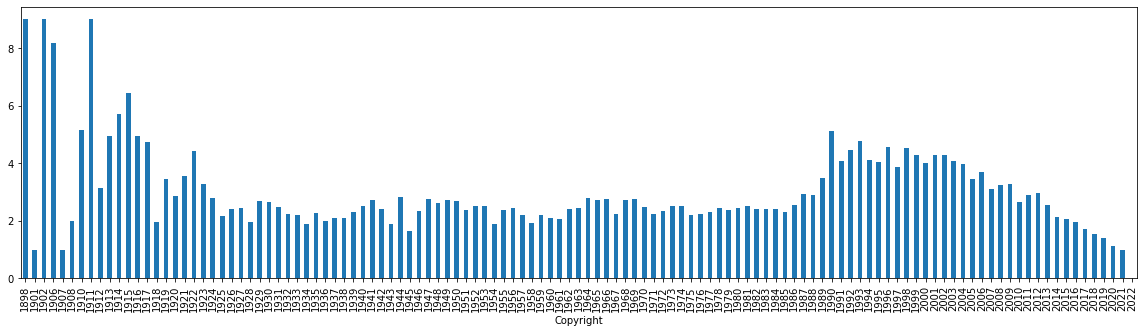

In [9]:
konce.groupby("Copyright")["Pauza"].mean().plot.bar(figsize=(20,5))

In [10]:
r3 = konce.groupby("Jméno")["Copyright"].nunique()
r3 = r3[r3 >= 5]
r3 = r3.index.to_list()

In [11]:
k3 = konce[konce["Jméno"].isin(r3)]

In [12]:
k3 = k3[k3["Copyright"].isin(range(1920,2011))]

In [13]:
k3 = k3.merge(persony[["Jméno","Rok úmrtí"]], on="Jméno")

In [14]:
k3["Příští film"] = pd.to_numeric(k3["Příští film"], errors="coerce")

In [15]:
k3["Rok úmrtí"] = pd.to_numeric(k3["Rok úmrtí"], errors="coerce")

In [16]:
k3.loc[k3["Příští film"] > k3["Rok úmrtí"],"Příští film"]=None

In [17]:
k3.groupby("Copyright")["Jméno"].nunique()

Copyright
1920    113
1921    138
1922    130
1923     81
1924     78
       ... 
2006    637
2007    545
2008    704
2009    817
2010    673
Name: Jméno, Length: 91, dtype: int64

In [18]:
k3.sample(5)

,Copyright,Jméno,Příští film,Pauza,Rok úmrtí
61063,1995,Šárka Cimbalová (85990),2014.0,19.0,NaN
61788,2006,Kristýna Nováková (6366),2007.0,1.0,NaN
50106,1992,Jaroslav Šámal (1403),1998.0,6.0,NaN
27330,1989,Lubomír Bryg (126444),NaN,NaN,1994.0
16921,1981,Jaroslav Mareš (17561),1983.0,2.0,2003.0


<AxesSubplot:xlabel='Copyright'>

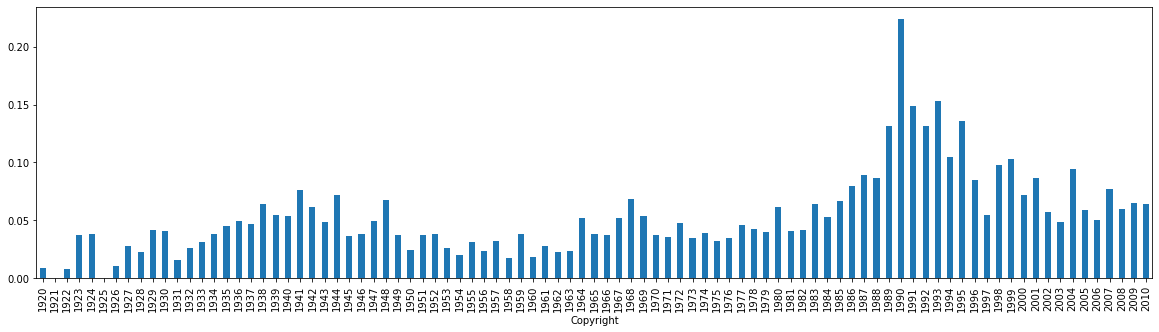

In [19]:
pd.Series(k3[k3["Pauza"].isnull()].groupby("Copyright")["Jméno"].nunique() / k3.groupby("Copyright")["Jméno"].nunique()).plot.bar(figsize=(20,5))

In [20]:
k3[k3["Copyright"] == 1992]

,Copyright,Jméno,Příští film,Pauza,Rok úmrtí
9163,1992,Svatopluk Beneš (13617),2003.0,11.0,2007.0
9735,1992,Nelly Gaierová (4888),1993.0,1.0,1995.0
9736,1992,Nelly Gaierová (4888),1993.0,1.0,1995.0
11417,1992,Jiřina Bohdalová (2878),1993.0,1.0,NaN
12425,1992,Karel Černý (1241),2001.0,9.0,2014.0
...,...,...,...,...,...
60415,1992,Pavel Dvořák (1294),1993.0,1.0,NaN
60428,1992,Viktor Fančovič (6500),1994.0,2.0,NaN
60435,1992,Martin Engel (2610),1993.0,1.0,NaN
60439,1992,Martin Písařík (18968),1993.0,1.0,NaN


<AxesSubplot:xlabel='Copyright'>

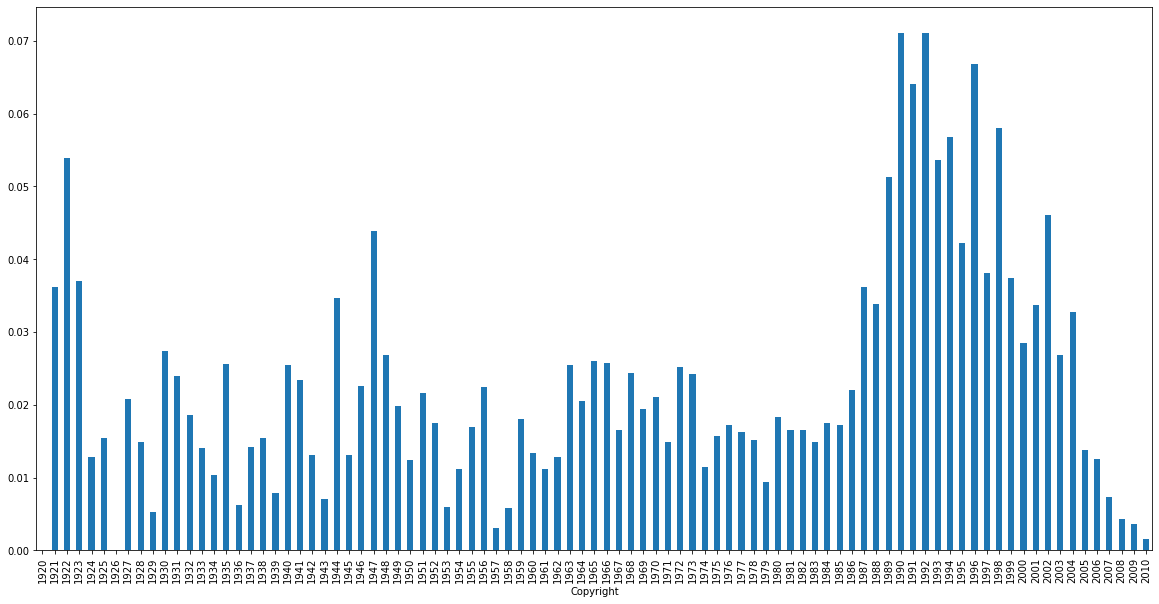

In [21]:
pd.Series(k3[(k3["Pauza"] >= 12)].groupby("Copyright")["Jméno"].nunique() / k3.groupby("Copyright")["Jméno"].nunique()).plot.bar(figsize=(20,10))

<AxesSubplot:xlabel='Copyright'>

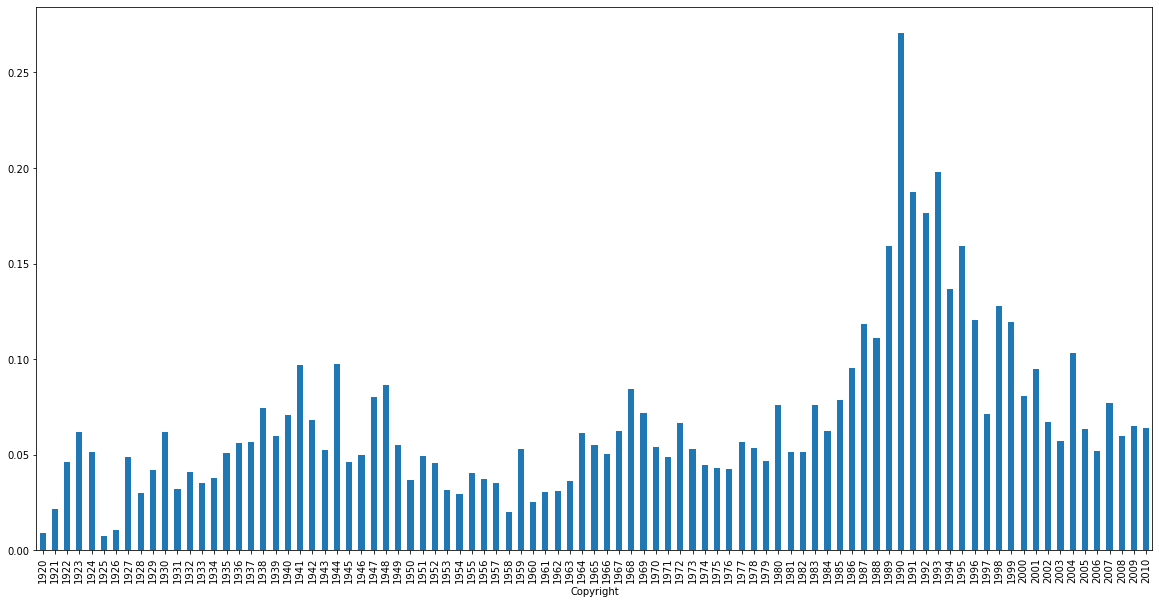

In [22]:
pd.Series(k3[(k3["Pauza"] >= 15) | (k3["Pauza"].isnull())].groupby("Copyright")["Jméno"].nunique() / k3.groupby("Copyright")["Jméno"].nunique()).plot.bar(figsize=(20,10))

<AxesSubplot:xlabel='Copyright'>

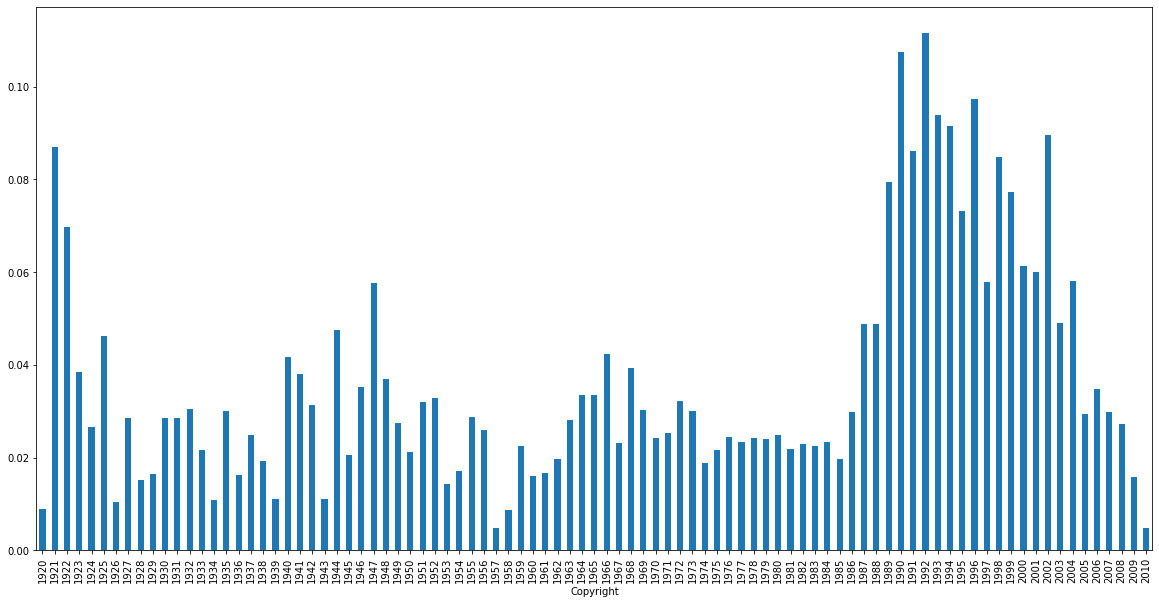

In [23]:
pd.Series(k3[(k3["Pauza"] >= 10)].groupby("Copyright")["Jméno"].nunique() / k3[~k3["Pauza"].isnull()].groupby("Copyright")["Jméno"].nunique()).plot.bar(figsize=(20,10))